In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

In [2]:
# Data paths
case = ''
data_path_taker = 'output_data/btes_base_case_orca_{0}price_taker/btes_output_price_taker_base_BTES_costsx#COST.pickle'.format(case)
data_path_maker = 'output_data/btes_base_case_orca{0}/btes_output_BTES_costsx#COST.pickle'.format(case)

# Prices to scan
prices = ['1p0', '0p1', '0p25','0p5', '0p75', '0p765', '0p77', '0p9']

# Colors
colors = {'price_taker': '#DE3163', 'price_maker': '#00008B'}
color_shades = {'price_taker': ['#f091ac', '#e54573', '#c0063b'], 'price_maker': ['#9c9cea', '#5757d3', '#04049d']}

In [3]:
def get_btes_investment(component_results):
    """
    Get capital expenditure for BTES, i.e. sum of discharge, charge and energy store investment
    """
    btes_investment = 0
    for comp in [('Link','BTES_charger'), ('Link','BTES_discharger'), ('Store','granite')]:
        btes_investment += component_results[component_results.index == comp]['Capital Expenditure [$]'].values[0]
    return btes_investment

In [4]:
def read_output_file(filename):
    """
    Read file results
    """
    with open(filename, 'rb') as f:
        data = pickle.load(f)

        # Get cost from file name
        btes_cost = (filename.split('_')[-1].split('.')[0])

        # Get results from file
        case_data = data['case results']
        comp_results = data['component results']
        time_results = data['time results']

        return case_data, comp_results, time_results, btes_cost
    

In [5]:
def plot_bars_maker_taker(x,y, xlabel, ylabel, title=None, split_bars=False):
    """
    Plot bar chart for price maker and price taker
    """
    plt.figure()
    x_ticks = np.arange(len(x))
    multiplier = 0
    width =  0.25
    for run,cost in y.items():
        offset = width * (multiplier+0.5)
        if not split_bars:
            plt.plot(x, cost, 'o', color=colors[run], label=run)
            plt.plot(x, cost, color=colors[run], label=run)
        else:
            for iv,vals in enumerate(cost):
                bottom = 0
                for j,nums in enumerate(vals):
                    plt.bar(x_ticks[iv]+offset, nums/sum(vals), width=width, label=run, bottom=bottom, 
                            color=color_shades[run][j])
                    bottom += nums/sum(vals)
            plt.xticks(x_ticks+width, x)

        multiplier += 1

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title if title else '')
    # Get unique legend entries
    if not split_bars:
        handles, labels = plt.gca().get_legend_handles_labels()
        labels = [label.replace('_', ' ').capitalize() for label in labels]
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
    else:
        # Custom legend
        legend_elements = [
            Patch(facecolor=colors['price_maker'], label='Price maker'),
            Patch(facecolor=colors['price_taker'], label='Price taker'),
            Patch(facecolor='#747474', label='Storage'),
            Patch(facecolor='#b0b0b0', label='Charger'),
            Patch(facecolor='#e3e3e3', label='Discharger'),
        ]

        # Put legend outside of plot
        plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.5))

    # Save figure
    plt.savefig('figures/btes_{0}.jpg'.format(title.replace(' ','_').replace(',','').lower()), bbox_inches='tight', dpi=500)


In [6]:
def plot_curve_maker_taker(var, run, xlabel, ylabel, title=None):
    """
    Plot curve for price maker and price taker
    """
    plt.plot(var, label=run)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title if title else '')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1, 0.5))
    # Save figure
    if not os.path.exists('figures'):
        os.makedirs('figures')
    plt.savefig('figures/btes_energy_in_store.jpg', bbox_inches='tight')

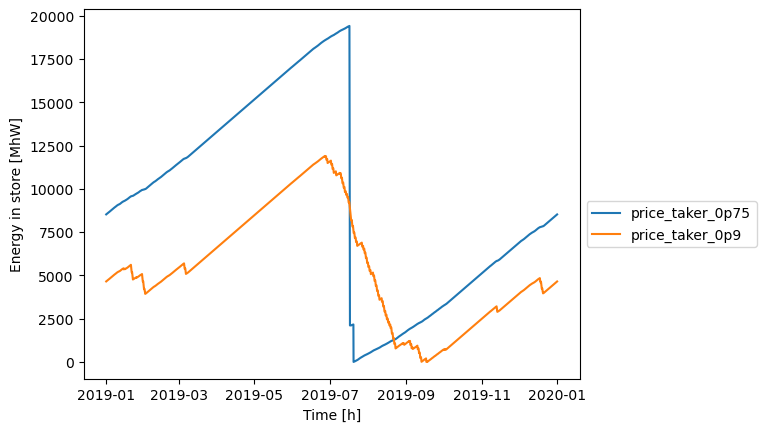

In [7]:
# Collect results
rev_per_inv = {'price_maker': [], 'price_taker': []}
discharge_time = {'price_maker': [], 'price_taker': []}
inv = {'price_maker': [], 'price_taker': []}
capacity = {'price_maker': [], 'price_taker': []}
capacity_store = {'price_maker': [], 'price_taker': []}
energy_in_store = {'price_maker': [], 'price_taker': []}
capacity_increase = {'price_maker': [], 'price_taker': []}
discharge_capacity_increase = {'price_maker': [], 'price_taker': []}
base_capacity = {'price_maker': [], 'price_taker': []}
base_capacity_discharger = {'price_maker': [], 'price_taker': []}

# Loop over prices in descending order
for price in prices:
    # Get results
    for run in ['maker', 'taker']:
        case_res, comp_res, time_res, btes_cost = read_output_file(data_path_maker.replace('#COST', str(price)) if run == 'maker' else data_path_taker.replace('#COST', str(price)))

        # Calculate revenue per investment
        btes_investment = get_btes_investment(comp_res)
        if run =='maker':
            no_btes_file = 'output_data/btes_base_case_orca_no_btes/btes_output_no_btes.pickle'
            cost_no_btes = read_output_file(no_btes_file)[0]['objective [$]'].values[-1]
            cost = cost_no_btes - (case_res['objective [$]'].values[-1] - btes_investment)
        else:
            cost = abs(case_res['objective [$]'].values[-1] - btes_investment)
        cost = cost / btes_investment
        rev_per_inv['price_maker' if run == 'maker' else 'price_taker'].append(cost)

        # Calculate discharge_time
        granite = comp_res[comp_res.index == ('Store', 'granite')]
        discharger = comp_res[comp_res.index == ('Link', 'BTES_discharger')]
        charger = comp_res[comp_res.index == ('Link', 'BTES_charger')]

        granite_opt_cap = granite['Optimal Capacity [MW]'].values[0]
        discharger_opt_cap = discharger['Optimal Capacity [MW]'].values[0] 
        dur = granite_opt_cap / discharger_opt_cap

        discharge_time['price_maker' if run == 'maker' else 'price_taker'].append(dur)

        # Get investment
        inv['price_maker' if run == 'maker' else 'price_taker'].append([discharger['Capital Expenditure [$]'].values[0], charger['Capital Expenditure [$]'].values[0], granite['Capital Expenditure [$]'].values[0]])
        
        # Get energy capacity
        
        if price == '1p0':
            base_capacity['price_maker' if run == 'maker' else 'price_taker'].append(granite_opt_cap)
            base_capacity_discharger['price_maker' if run == 'maker' else 'price_taker'].append(discharger_opt_cap)
        capacity_increase['price_maker' if run == 'maker' else 'price_taker'].append(granite_opt_cap/base_capacity['price_maker' if run == 'maker' else 'price_taker'][-1])
        discharge_capacity_increase['price_maker' if run == 'maker' else 'price_taker'].append(discharger_opt_cap/base_capacity_discharger['price_maker' if run == 'maker' else 'price_taker'][-1])

        # Get energy in store
        # Only plot for price taker for 0.75 and 0.9
        if run == 'taker' and price in ['0p75', '0p9']:
            plot_curve_maker_taker(time_res['granite e'], ('price_maker' if run == 'maker' else 'price_taker')+'_'+price, 'Time [h]', 'Energy in store [MhW]')
        
        # Add optimal capacity for all components
        if run == 'maker':
            capacities = comp_res[~comp_res.index.get_level_values(0).isin(['Load', 'Store'])]['Optimal Capacity [MW]']
            # Drop level 0 of index
            capacities.index = capacities.index.droplevel(0)
            capacity['price_maker'].append(capacities)

            capacities_store = comp_res[comp_res.index.get_level_values(0) == 'Store']['Optimal Capacity [MW]']
            capacities_store.index = capacities_store.index.droplevel(0)
            capacity_store['price_maker'].append(capacities_store)


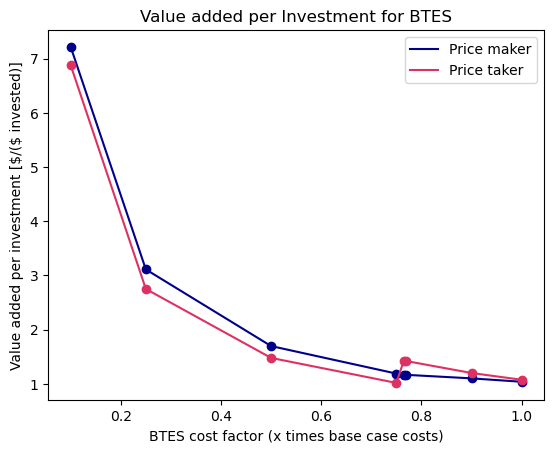

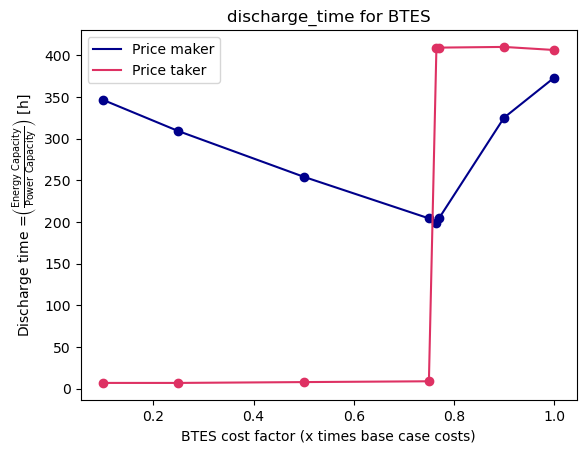

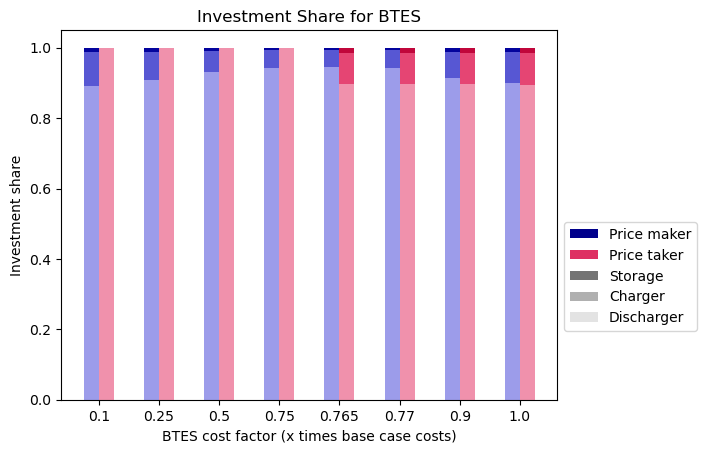

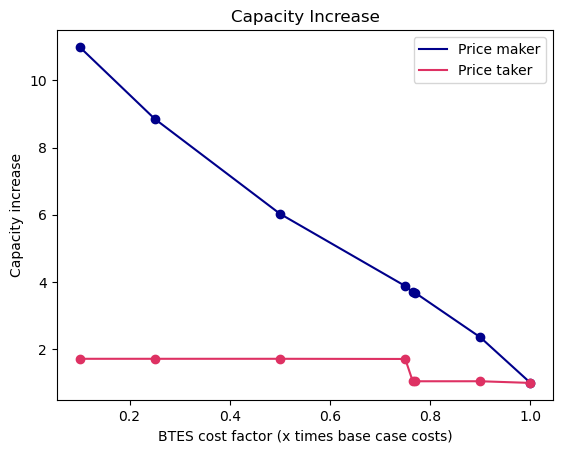

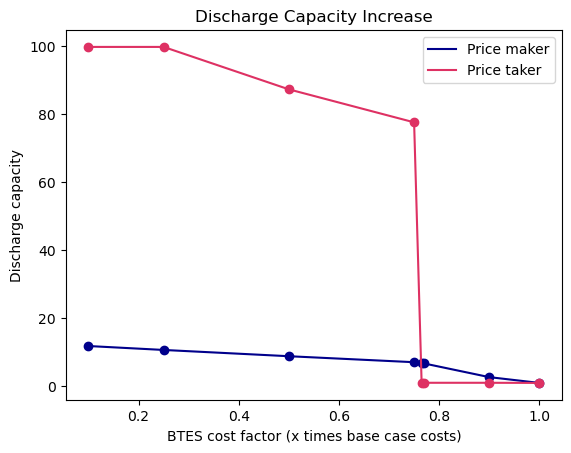

In [8]:
# Replace p with . in prices
prices_float = sorted([float(price.replace('p', '.')) for price in prices])
# for rev_per_inv, discharge_time, inv, capacity_increase, discharge_capacity_increase move first element to last
for key in [rev_per_inv, discharge_time, inv, capacity_increase, discharge_capacity_increase]:
    for k,v in key.items():
        key[k] = v[1:] + [v[0]]
# Plot revenue per investment
plot_bars_maker_taker(prices_float, rev_per_inv, 'BTES cost factor (x times base case costs)', 'Value added per investment [$/(\$ invested)]', 'Value added per Investment for BTES')
# Plot discharge_time
plot_bars_maker_taker(prices_float, discharge_time, 'BTES cost factor (x times base case costs)', r'Discharge time =$\left( \frac{\mathrm{Energy \ Capacity}}{\mathrm{Power \ Capacity}} \right)$ [h]', 'discharge_time for BTES')
# Plot investment share
plot_bars_maker_taker(prices_float, inv, 'BTES cost factor (x times base case costs)', 'Investment share', 'Investment Share for BTES', split_bars=True)
# Plot capacity per investment
plot_bars_maker_taker(prices_float, capacity_increase, 'BTES cost factor (x times base case costs)', 'Capacity increase', 'Capacity Increase')
# Plot discharge capacity per investment
plot_bars_maker_taker(prices_float, discharge_capacity_increase, 'BTES cost factor (x times base case costs)', 'Discharge capacity', 'Discharge Capacity Increase')

In [9]:
color_map = {
    'solar-utility': 'yellow',
    'solar-rooftop': 'lightgreen',
    'onwind': 'lightblue',
    'Lithium-Ion-LFP-bicharger': 'purple',
    'Lithium-Ion-LFP-bicharger % discharge': 'indigo',
    'Lithium-Ion-LFP-store': 'blue',
    'nuclear': 'orange',
    'CCGT': 'gray',
    'oil': 'black',
    'hydrogen storage underground': 'lightpink',
    'electrolysis': 'pink',
    'fuel cell': 'hotpink',
    'granite': 'red',
    'BTES_charger': 'darkred',
    'BTES_discharger': 'darkorange',
    'load': 'darkblue',
    'lost_load': 'darkgreen',
    'lost load': 'darkgreen',}

In [10]:
# Plot capacity for maker per component
def plot_capacity(prices, capacity, color_map, store=False):
    fig, ax = plt.subplots()
    for i, cap in enumerate(capacity['price_maker']):
        print(cap)
        print(cap.values)
        print(cap.index)
        # Stacked bar chart
        for j, val in enumerate(cap.values):
            print(cap.index[j])
            ax.bar(prices[i], val, bottom=sum(cap.values[:j]), label=cap.index[j], color=color_map[cap.index[j]])
    plt.xlabel('BTES cost factor (x times base case costs)')
    plt.ylabel('Optimal capacity [MW]')
    plt.ylim(0, max([sum(capacity['price_maker'][i].values) for i in range(len(prices))])*1.1)
    # Only show each label once in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1, 1))
    plt.savefig('figures/btes_capacity_all.jpg')

    # Plot capacity for maker
    # ax.bar(prices, capacity['price_maker'], color='red' if store else 'blue', label='BTES discharger' if not store else 'granite')
    # plt.xlabel('BTES cost factor (x times base case costs)')
    # plt.ylabel('Optimal capacity [{0}]'.format('MW' if not store else 'MWh'))
    # plt.legend()
    # plt.savefig('figures/btes_capacity_{0}.jpg'.format('store' if store else 'discharger'), bbox_inches='tight', dpi=500)

CCGT                                     469241.00000
lost_load                                     0.00000
oil                                       57620.75672
onwind                                        0.00000
solar-utility                            305048.76086
BTES_charger                               2373.82189
BTES_discharger                           24709.56808
Lithium-Ion-LFP-bicharger                 57203.13318
Lithium-Ion-LFP-bicharger % discharge     60213.82440
electrolysis                                  0.00000
fuel cell                                     0.00000
Name: Optimal Capacity [MW], dtype: float64
[469241.           0.       57620.75672      0.      305048.76086
   2373.82189  24709.56808  57203.13318  60213.8244       0.
      0.     ]
Index(['CCGT', 'lost_load', 'oil', 'onwind', 'solar-utility', 'BTES_charger',
       'BTES_discharger', 'Lithium-Ion-LFP-bicharger',
       'Lithium-Ion-LFP-bicharger % discharge', 'electrolysis', 'fuel cell'],
      dty

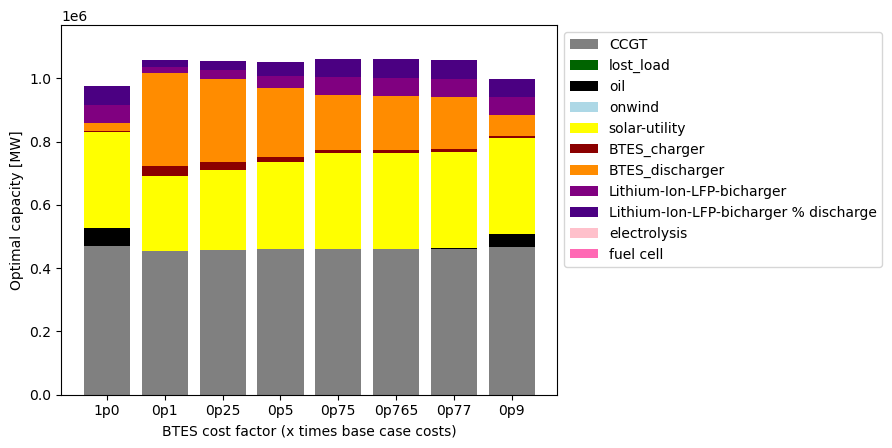

In [11]:
plot_capacity(prices, capacity, color_map)

Lithium-Ion-LFP-store           2.490548e+05
granite                         9.221226e+06
hydrogen storage underground    0.000000e+00
Name: Optimal Capacity [MW], dtype: float64
[ 249054.8382  9221226.48271       0.     ]
Index(['Lithium-Ion-LFP-store', 'granite', 'hydrogen storage underground'], dtype='object')
Lithium-Ion-LFP-store
granite
hydrogen storage underground
Lithium-Ion-LFP-store           5.463907e+04
granite                         1.013557e+08
hydrogen storage underground    0.000000e+00
Name: Optimal Capacity [MW], dtype: float64
[5.46390733e+04 1.01355734e+08 0.00000000e+00]
Index(['Lithium-Ion-LFP-store', 'granite', 'hydrogen storage underground'], dtype='object')
Lithium-Ion-LFP-store
granite
hydrogen storage underground
Lithium-Ion-LFP-store           8.212140e+04
granite                         8.162462e+07
hydrogen storage underground    0.000000e+00
Name: Optimal Capacity [MW], dtype: float64
[   82121.40331 81624621.01825        0.     ]
Index(['Lithium-Ion-LFP

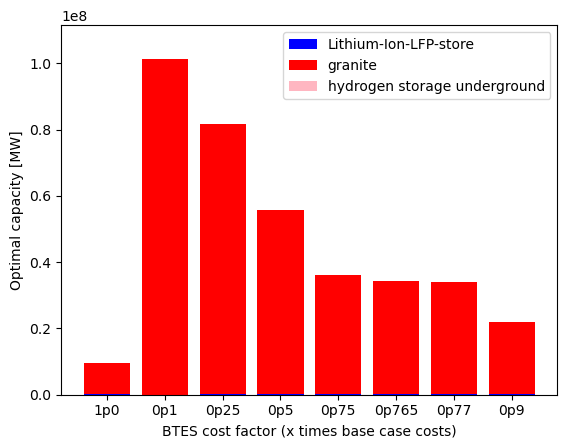

In [12]:
# Plot capacity for store
plot_capacity(prices, capacity_store, color_map, store=True)